# Gross-Vitells LEE toy example

For an more detailed description of using this method in the context of a bump hunt,  [see this notebook](https://github.com/naodell/nllfit/blob/master/examples/gross_vitells_higgs.ipynb).  In this notebook, I will do a more abstracted GV analysis: rather than starting from a real world analysis challenge, I'm just going to generate a number of toy $\chi^{2}_{k}$ fields and then carry out the GV scheme.

In [2]:
# imports and configuration

%cd '/home/naodell/work/projects/nllfit'
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
from scipy.stats import norm, chi2
from tqdm import tqdm_notebook, tnrange

from nllfit import Parameters, ScanParameters, Model, NLLFitter
import nllfit.fit_tools as ft
import nllfit.lookee as lee

#%qtconsole

/home/naodell/work/projects/nllfit


The first step will be to produce our toy data.  In the simplest case, each on the manifold will be distributed according to a $\chi^{2}_{k}$.  Let's limit our focus to a two dimensional manifold.  To get to the $\chi^{2}$ manifold, we first generate a $n\times m$ normally distributed variates.  Since this is the case of $\mu=0$ and $\sigma=1$, we can get the $\chi^{2}$ variates by squaring each of the normally distributed variates.

<IPython.core.display.Javascript object>


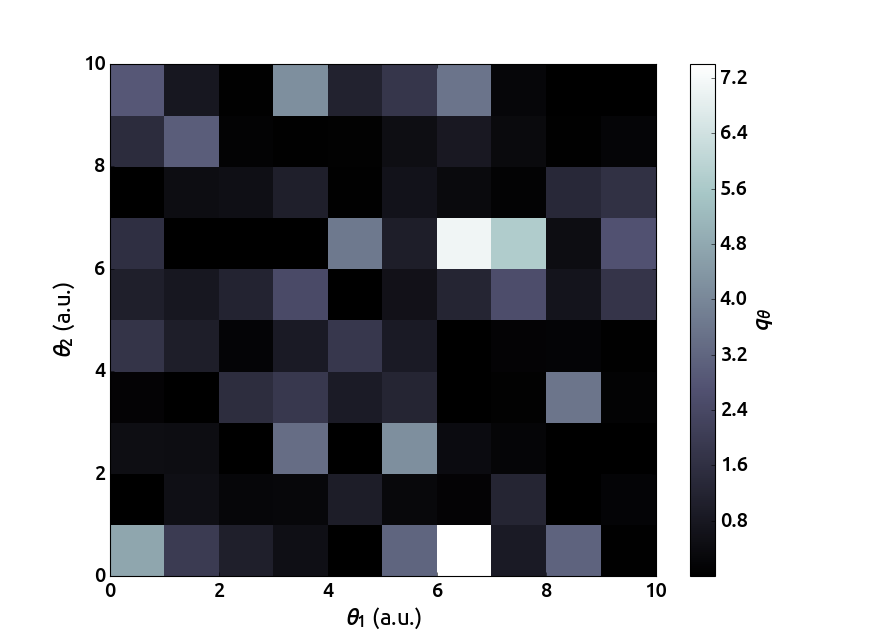

In [33]:
n = 11
q = np.power(np.random.randn(n, n), 2)
x, y = np.mgrid[slice(0, n, 1), slice(0, n, 1)]
plt.pcolormesh(x, y, q, cmap='bone')
plt.xlabel(r'$\theta_{1}$ (a.u.)')
plt.ylabel(r'$\theta_{2}$ (a.u.)')
cbar = plt.colorbar()
cbar.set_label(r'$q_{\theta}$')

Looks pretty random!  Now let's get some intuition about what the excursion, $\mathcal{A}_{u}$ set.  Basically, we will consider the number of points that have values above $u$ while successively raising the threshold $u$.  For simplicity, I will binarize the image so that values of $q_{\theta} < u$ are white and values $q_{\theta} \geq u$ are black.  Here I scan values of $u \in \mathbb{N}$ between 1 and 16.  For each scan point I calculate the E.C.

<IPython.core.display.Javascript object>


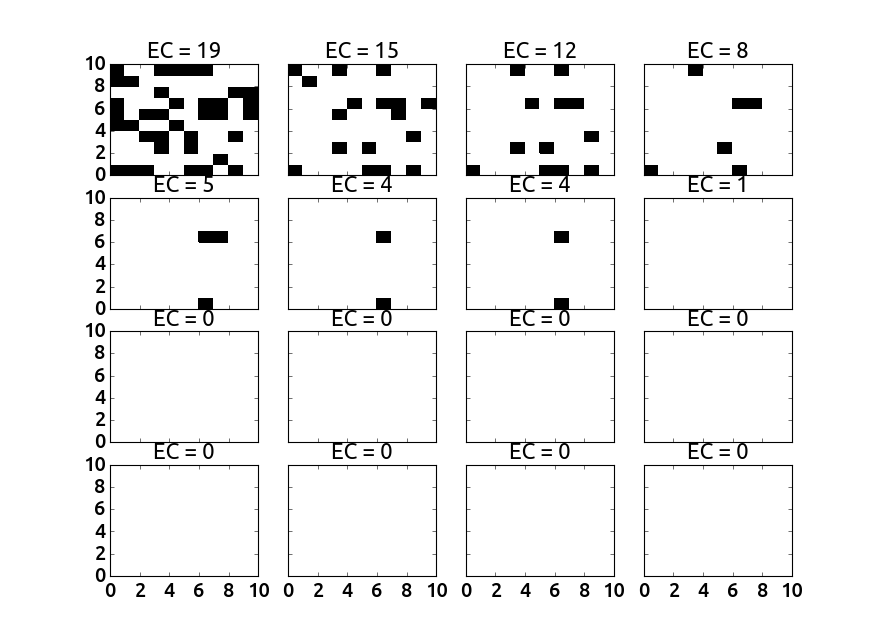

In [34]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True)
for u in range(1,17):
    au = (q>u) + 0.
    ec = lee.calculate_euler_characteristic(au)
    
    ax = axes[(u-1)/4][(u-1)%4]
    ax.pcolormesh(x, y, au, cmap='Greys')
    ax.set_title('EC = {0}'.format(ec))
    ax.autoscale(False)
    ax.grid(False)
    
plt.show()

In order to carry out the GV procedure, this will be repeated for many such pseudo experiments and then $\mathbb{E}[\phi(u)]$ can be constructed.

In [41]:
q_toys = np.random.randn(1000, 10, 10)
q_toys = np.power(q_toys, 2)
uvals  = np.linspace(1., 30, 145)

ecn  = []
qmax = []
for q in tqdm_notebook(q_toys):
    ec = []
    for u in uvals:
        au = (q>u) + 0.
        ec.append(lee.calculate_euler_characteristic(au))
    ecn.append(ec)
    qmax.append(np.max(q))
    
ecn  = np.array(ecn)
qmax = np.array(qmax)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [42]:
h, b = np.histogram(qmax, bins=30, range=(0., 30.), normed=True)
h    = 1 - np.cumsum(h)

plt.plot(b[1:], h, 'b')
plt.plot(uvals, np.mean(ecn, axis=0), 'r')

plt.xlabel(r'$\sf u$')
plt.ylabel(r'')
plt.xlim(1, 30)
plt.ylim(1e-3, 1e4)
plt.legend([r'$\sf 1 - CDF(q_{max})$', r'$\mathbb{E}[\phi_{u}]$'])
plt.yscale('log')
plt.show()

So for this $\chi^{2}$ field it is clear that the expectation of the E.C. and the survival function for likelihood ratio correspond very closely.  This gives credence to the statement that for sufficiently large excursions, $u$,

$$\mathbb{E}[\phi_{u}] \approx \mathbb{P}[q_{\theta} > u]$$

Now the E.C. expansion coefficients, $\mathcal{N}_{d}$ can be calculated.

In [43]:
param_init = [1.,1.]
param_bnds = [(-np.inf, np.inf), (-np.inf, np.inf)]
nvals      = lee.get_GV_coefficients(uvals, ecn, param_init, param_bnds, kvals=[1], scales=[1])
print nvals

[ 79.188  14.867]


<IPython.core.display.Javascript object>


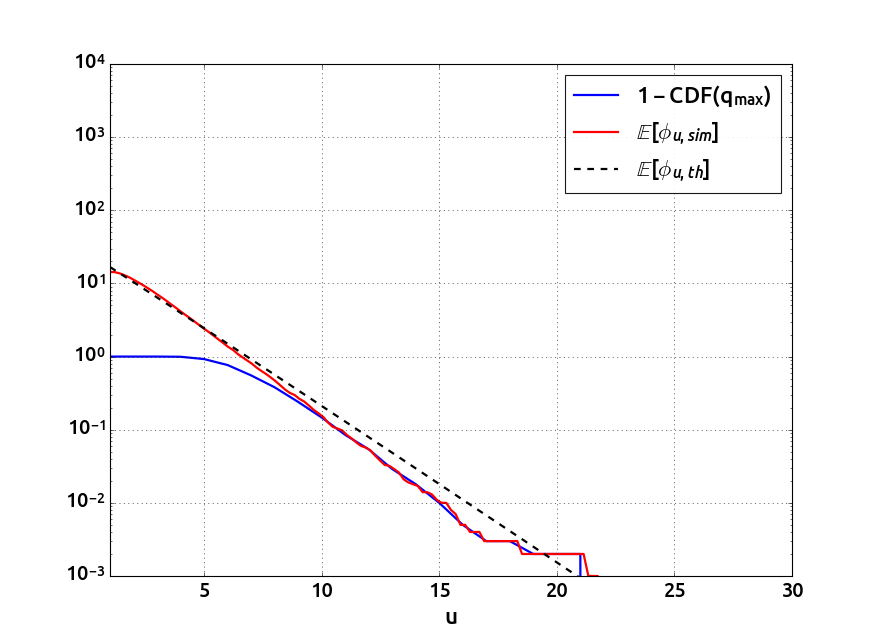

In [51]:
h, b = np.histogram(qmax, bins=30, range=(0., 30.), normed=True)
h    = 1 - np.cumsum(h)

plt.plot(b[1:], h, 'b-')
plt.plot(uvals, np.mean(ecn, axis=0), 'r-')
plt.plot(uvals, lee.exp_phi_u(uvals, nvals, 1), 'k--')

# plt.plot(uvals, chi2.sf(uvals,1), 'm--')
# plt.plot(uvals, nvals[0]*lee.rho_g(uvals,1,1), 'g--')
# plt.plot(uvals, nvals[1]*lee.rho_g(uvals,2,1), 'c--')

plt.xlabel(r'$\sf u$')
plt.ylabel(r'')
plt.xlim(1, 30)
plt.ylim(1e-3, 1e4)
plt.legend([r'$\sf 1 - CDF(q_{max})$', r'$\mathbb{E}[\phi_{u,sim}]$', r'$\mathbb{E}[\phi_{u,th}]$'])
plt.yscale('log')
plt.show()